In [1]:
import ROOT as rt
import uproot
import numpy as np
from collections import OrderedDict
import os
import sys
from array import array
sys.path.append(os.getcwd().replace('scripts', 'lib'))

import tdrstyle
a = tdrstyle.setTDRStyle()

print(sys.version)

Welcome to JupyROOT 6.28/00
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


# load signal ntuples

Load signal ntuples with 4 different LLP lifetimes (0.1, 1, 10, 100m) that contain generator-level LLP information

In [8]:
fpath =OrderedDict()
tree = OrderedDict()

mass = [40]

OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

path = '/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/signal/nocuts/'

for ct in OLD_CTAU:
    key = 'MC_40_'+str(ct)                       
    fpath[key] = path +  'ggH_HToSSTobbbb_MH-125_MS-40_ctau-'+str(ct)+'_137000pb_weighted.root'

    
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']


# Ex1 - calculate the LLP proper decay length from the LLP four momentum

Here you will calculate the LLP proper decay length by converting from the lab frame decay length to the decay length in the LLP's rest frame, with the following equation:
$d = \beta\gamma\tau$, where d is the lab frame decay length, $\beta$ is the LLP velocity, $\gamma$ is the LLP Lorentz factor, and $\tau$ is the LLP proper decay lifetime.

You will use the following branches in the ROOT tree 
* `gLLP_decay_vertex_x`, in units of cm
* `gLLP_decay_vertex_y`, in units of cm
* `gLLP_decay_vertex_z`, in units of cm
* `gLLP_beta` , ranges from 0 to 1

In [10]:
gLLP_ctau = {}
for k, T in tree.items():
    gLLP_decay_vertex = np.sqrt(T['gLLP_decay_vertex_x'].array()**2 + T['gLLP_decay_vertex_y'].array()**2 + T['gLLP_decay_vertex_z'].array()**2)
    gLLP_gamma = 1.0/np.sqrt(1-T['gLLP_beta'].array()**2)
    gLLP_ctau[k] = gLLP_decay_vertex/(T['gLLP_beta'].array()*gLLP_gamma)

# Ex1 - plot the LLP proper decay length

In this exercise, you will plot the `gLLP_ctau` array for 1m and 10m sample.
You will then perform an exponential fit to verify that the shape is exponential and linear in logY scale.
From the exponential fit, you can extract the mean proper decay length of the LLP and verify that it agrees with what you expect from the sample (1m or 10m)


sample: MC_40_1000, fitted ctau [mm]: 1010.7581684098009
sample: MC_40_10000, fitted ctau [mm]: 10036.598396741669
CPU times: user 4.2 s, sys: 23.1 ms, total: 4.22 s
Wall time: 4.21 s
 FCN=5.00382 FROM MIGRAD    STATUS=CONVERGED      47 CALLS          48 TOTAL
                     EDM=7.53627e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.92745e-02   1.49468e-02   1.19673e-05   3.19037e-03
   2  Slope       -9.89356e-03   1.01734e-04   8.14485e-08   5.65645e-01
 FCN=48.7055 FROM MIGRAD    STATUS=CONVERGED      58 CALLS          59 TOTAL
                     EDM=3.62339e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.31010e+00   1.41669e-02   3.45201e-05  -1.75661

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


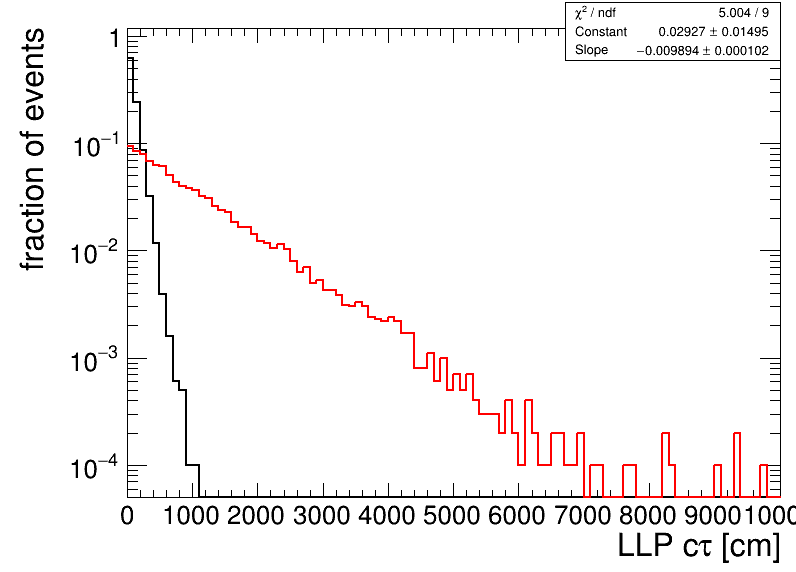

In [20]:
%%time

Nevents_todraw = 10000
c = rt.TCanvas('c','c', 800, 600)
h = {}

for i, k in enumerate([ 'MC_40_1000', 'MC_40_10000']):
    h[k] = rt.TH1D('', '', 100, 0, 10000)
    h[k].SetXTitle('LLP c#tau [cm]')
    h[k].SetYTitle('fraction of events')
    for j in range(Nevents_todraw): h[k].Fill(gLLP_ctau[k][j][0])
    h[k].Scale(1./h[k].Integral())
    h[k].SetLineColor(i+1)
    h[k].Draw('hist same')

    ####### perform exponential fit ######
    h[k].Fit('expo')
    fit = h[k].GetFunction('expo')
    print("sample: {}, fitted ctau [mm]: {}".format(k, -1./fit.GetParameter(1)*10))
    #######################################
    
c.SetLogy()
c.Draw()


# Ex2 - reweight LLP lifetime 

In this exercise you will learn how to reweight the LLP lifetime.

In these signal events, there are two LLPs and the decay position of the two LLPs in each event are independent, and each LLP decays with an exponential probability, the distribution of events is simply the product of the two LLP decay probabilities:
\begin{equation}
  p(t_1, t_2 | \tau) = \frac{1}{\tau^2}\exp^{-t_1/\tau}\exp^{-t_2/\tau}
\end{equation}
where $\tau$ is the mean proper decay length of the LLPs, and $t_1$ and $t_2$ are the lifetimes of the first LLP and second LLP in their own rest frame respectively, which are the `gLLP_ctau` variable that you have calculated in Ex1.

To obtain a sample with lifetime $\tau_{new}$ from a sample with lifetime $\tau_{old}$, we
assign a weight, which is the ratio between equation above with parameter $\tau_{new}$
and:
\begin{equation}
  w = (\frac{\tau_{old}}{\tau_{new}})^2 \exp[(t_1+t_2)\times(\frac{1}{\tau_{old}}-\frac{1}{\tau_{new}})]
\end{equation}

You will implement this equation in the function `weight_calc` below

In [14]:
'''
arguements: 
llp_ctau is the list of sum of proper decay length, which is t1+t2 in the equation
new_ctau is tau_new in the equation
old_ctau is tau_old in the equation
All units in cm

return event weight 

'''


def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

## reweight from 10m to 1m

In this exercise you will use the reweighting function that you have just implemented to reweight the 10m sample to 1m and plot it against the original 1m sample to validate the reweighting function
You will then perform an exponential fit to verify that the extracted mean proper decay length of the LLP is 1m for both

sample: MC_40_1000, fitted ctau [mm]: 1001.191672678267
sample: MC_40_10000, fitted ctau [mm]: 977.1577014815783
CPU times: user 4.93 s, sys: 22.8 ms, total: 4.95 s
Wall time: 4.94 s
 FCN=62.0214 FROM MIGRAD    STATUS=CONVERGED      54 CALLS          55 TOTAL
                     EDM=4.31598e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.30848e+00   1.40586e-02   3.88781e-05   8.53937e-02
   2  Slope       -9.98810e-03   9.89488e-05   2.73426e-07   4.86514e+00
 FCN=115.995 FROM MIGRAD    STATUS=CONVERGED      50 CALLS          51 TOTAL
                     EDM=6.0767e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.37942e+00   5.14333e-02   1.58356e-04   3.66494e-

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


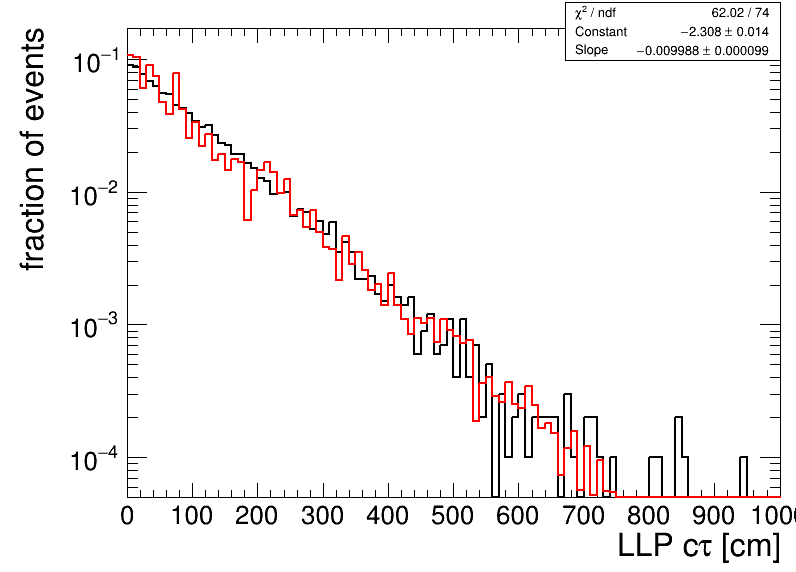

In [21]:
%%time
c = rt.TCanvas('c','c', 800, 600)
h = {}
Nevents_todraw = 10000

for i, k in enumerate(['MC_40_1000', 'MC_40_10000']):
    h[k] = rt.TH1D('', '', 100, 0, 1000)
    h[k].SetXTitle('LLP c#tau [cm]')
    h[k].SetYTitle('fraction of events')
    
    if k == 'MC_40_1000': 
        for j in range(Nevents_todraw): h[k].Fill(gLLP_ctau[k][j][0])
    else: 
        weight = weight_calc(np.sum(gLLP_ctau[k], axis = 1), 100,1000)
        for j in range(Nevents_todraw): h[k].Fill(gLLP_ctau[k][j][0], weight[j])
    
    h[k].Scale(1./h[k].Integral())
    h[k].SetLineColor(i+1)
    h[k].Draw('hist same')
    

    ####### perform exponential fit ######
    h[k].Fit('expo')
    fit = h[k].GetFunction('expo')
    print("sample: {}, fitted ctau [mm]: {}".format(k, -1./fit.GetParameter(1)*10))

    #######################################
    
c.SetLogy()
c.Draw()


# Ex3 - Calculate the probability of LLP decaying in the muon system

In this exercise you will calculate the probability of the LLP decaying in the muon system by requiring the LLP decay vertex lies within the Muon system.
You will first define the geometric decay region of the muon system based on Fig. 4.1.1 on page 141 of the [Muon Detector Technical Design Report](https://cds.cern.ch/record/343814?ln=en) 
and calculate the probability of LLP decaying in the endcap muon detectors for LLP mean proper decay lenegths (0.1, 1, 10, 100m) that have been generated.

In [22]:
%%time

for k, T in tree.items():
    
    # define endcap muon system region
    sel_ms = np.logical_and(T['gLLP_eta'].array() <2.4, np.abs(T['gLLP_decay_vertex_z'].array()) < 1100)
    sel_ms = np.logical_and(sel_ms, np.abs(T['gLLP_decay_vertex_z'].array()) > 400)
    sel_ms = np.logical_and(sel_ms, np.abs(T['gLLP_decay_vertex_r'].array()) < 695.5)
    print(k, np.count_nonzero(np.sum(sel_ms, axis = 1))/len(sel_ms))

MC_40_100 0.01048640863979646
MC_40_1000 0.2217195242814668
MC_40_10000 0.2173056519093299
MC_40_100000 0.034945913899993554
CPU times: user 6.04 s, sys: 125 ms, total: 6.17 s
Wall time: 6.06 s


## calulate acceptance vs LLP mean proper decay length

Here we will extend on what we just did to calculate the acceptance for intermediate $c\tau$ by calling the 
reweighting function that you've written in the previous exercise to calculate the probability for other intermediate proper decay lengths.

In [35]:
%%time

ctau_list  = [100, 300, 500, 1000, 2000, 5000, 10000, 50000, 100000, 500000] #mm

acceptance = []
for ct in ctau_list:
    # find which sample to use for reweighting
    ct_source = 0
    for i in OLD_CTAU:
        if ct <= i: 
            ct_source = i
            break
    if ct_source == 0: ct_source = OLD_CTAU[-1]
    print(ct, ct_source) #verify the correct sample is chosen
    
    T = tree['MC_40_{}'.format(ct_source)]
    sel_ms = np.logical_and(T['gLLP_eta'].array() <2.4, np.abs(T['gLLP_decay_vertex_z'].array()) < 1100)
    sel_ms = np.logical_and(sel_ms, np.abs(T['gLLP_decay_vertex_z'].array()) > 400)
    sel_ms = np.logical_and(sel_ms, np.abs(T['gLLP_decay_vertex_r'].array()) < 695.5)
    weight = weight_calc(np.sum(T['gLLP_ctau'].array(), axis = 1), ct/10. , ct_source/10.) #convert to cm
    denominator = np.sum(weight)
    nominator = np.sum(weight[np.sum(sel_ms, axis = 1)>0])
    acceptance.append(nominator/denominator)
print(ctau_list, acceptance)

100 100
300 1000
500 1000
1000 1000
2000 10000
5000 10000
10000 10000
50000 100000
100000 100000
500000 100000
[100, 300, 500, 1000, 2000, 5000, 10000, 50000, 100000, 500000] [nan, 0.06518015, 0.12119633, 0.22171952, 0.30113977, 0.29137775, 0.21730565, 0.06569138, 0.034945913, 0.007605373]
CPU times: user 18.8 s, sys: 547 ms, total: 19.4 s
Wall time: 19 s


## plot acceptance vs LLP mean proper decay length

CPU times: user 1.3 ms, sys: 0 ns, total: 1.3 ms
Wall time: 1.29 ms


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


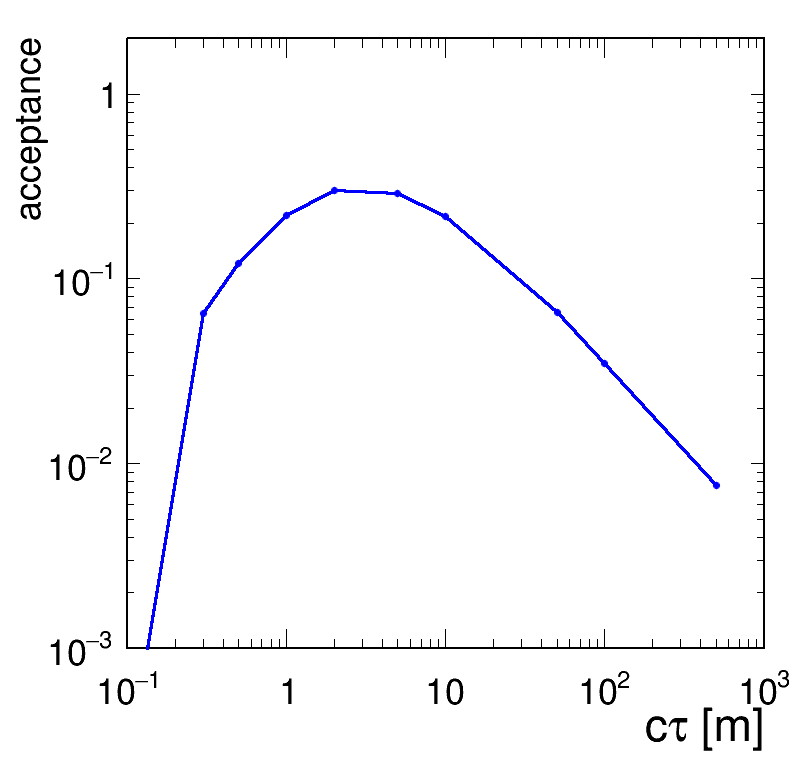

In [36]:
%%time

c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)

h = rt.TGraph(len(ctau_list),array("d", np.array(ctau_list)/1000.0), array("d", acceptance))

h.GetXaxis().SetTitle('c#tau [m]')
h.GetYaxis().SetTitle('acceptance')
h.GetXaxis().SetLimits(0.1,1000.0)
h.GetYaxis().SetRangeUser(1e-3,2)

h.GetXaxis().SetTitleOffset(1)
h.GetYaxis().SetTitleSize(0.05)
h.GetYaxis().SetTitleOffset(1.5)

h.SetLineWidth(3)
h.SetLineColor(4)
h.SetMarkerColor(4)

h.Draw('LPA')

c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)


tdrstyle.setTDRStyle()
c.Draw()